In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

In [27]:
# Etape 1 - Chargement des données
df = pd.read_csv('./data/employee-earnings-report-2021.csv', encoding='ISO-8859-1')

# Etape 2 - On enlève les lignes vides et inutiles
df = df.dropna(how='all')

# Etape 5 - Préparation des données pour prédiction
removed_columns = ['NAME', 'TITLE', 'POSTAL']

# Ces colonnes ne sont pas pertinentes pour prédire les valeurs
df.drop(removed_columns, axis=1, inplace=True)

# Etape 3 - Convertir en valeurs numériques Python
numeric_columns = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS']

def clean_numeric_column(column):
    # On supporte le format numérique monétaire bizarre des états-unis et on convertit en un type numérique Python
    return column.apply(lambda x: str(x).replace(',', '') if isinstance(x, str) else x).astype(float)

for column in numeric_columns:
    df[column] = clean_numeric_column(df[column])

In [28]:
# Etape 4 - Chercher des données aberrantes

model = IsolationForest()

df_outliers = df.copy()
df_outliers.fillna(0, inplace=True)
df_outliers['outlier'] = model.fit_predict(df_outliers[numeric_columns])
outliers = df_outliers[df_outliers['outlier'] == -1]
outlier_count = len(outliers)

outliers_sorted = outliers.sort_values(by=numeric_columns, ascending=False)

# Select the 6 most significant outliers
top_outliers = outliers_sorted.head(6)

# Remove them from the original df
df_cleaned = df.drop(top_outliers.index)

In [29]:
le = LabelEncoder()
df['DEPARTMENT_NAME'] = le.fit_transform(df['DEPARTMENT_NAME'].fillna('Unknown'))

# Séparation des données en attributs et cible
X = df[numeric_columns]
y = df['DEPARTMENT_NAME']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Méthodes d'imputation
imputers = {
    'zero': SimpleImputer(strategy='constant', fill_value=0),
    'median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'iterative': IterativeImputer(max_iter=10)
}

# Classifiers
classifiers = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Fonction pour évaluer les modèles et calculer les scores F1
def evaluate_models(imputer, classifier):
    # Applique l'imputation sur l'ensemble d'entraînement
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entraînement du classifieur
    classifier.fit(X_train_imputed, y_train)

    # Prédiction
    y_pred = classifier.predict(X_test_imputed)

    # Calcul des scores F1 micro et macro
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    return f1_micro, f1_macro

# Test des combinaisons d'imputation et de classifieurs
results = []
for imputer_name, imputer in imputers.items():
    for clf_name, clf in classifiers.items():
        f1_micro, f1_macro = evaluate_models(imputer, clf)
        results.append((imputer_name, clf_name, f1_micro, f1_macro))

# Conversion des résultats en DataFrame pour affichage
results_df = pd.DataFrame(results, columns=['Imputer', 'Classifier', 'F1 Micro', 'F1 Macro'])


In [30]:
# Exercice 7b - Appliquer la classe majoritaire à tous les éléments

majority_class = y_train.mode()[0]  # Classe la plus fréquente dans l'ensemble d'entraînement

y_pred_majority = [majority_class] * len(y_test)

f1_micro_majority = f1_score(y_test, y_pred_majority, average='micro')

f1_micro_majority

0.1286031042128603

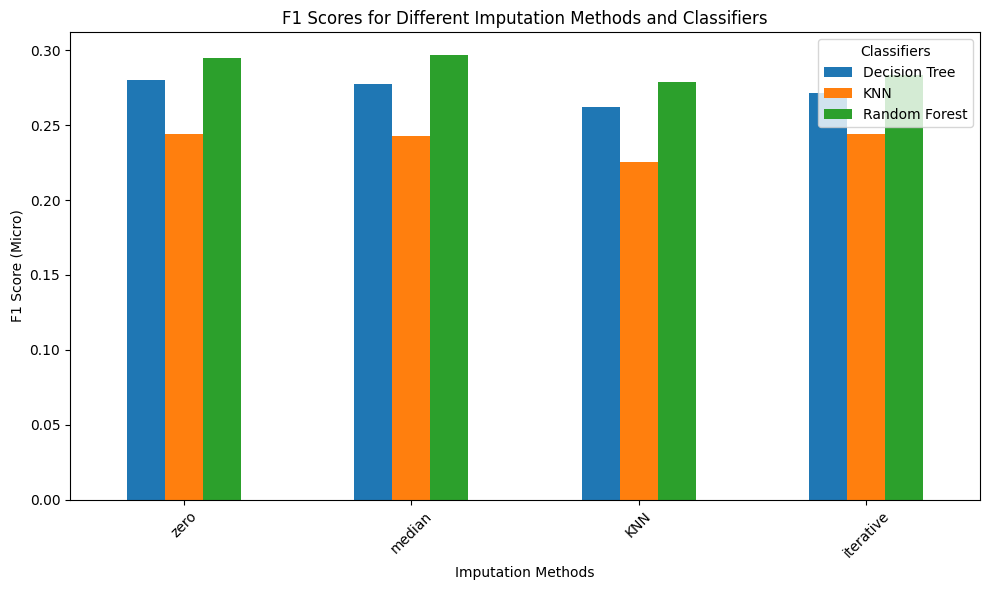

,Imputer,Classifier,F1 Micro,F1 Macro
0,zero,KNN,0.244346,0.041296
1,zero,Decision Tree,0.279823,0.066715
2,zero,Random Forest,0.294900,0.064966
3,median,KNN,0.242572,0.041344
4,median,Decision Tree,0.277605,0.069625
5,median,Random Forest,0.297118,0.069742
6,KNN,KNN,0.225277,0.037190
7,KNN,Decision Tree,0.262084,0.056497
8,KNN,Random Forest,0.278492,0.057578
9,iterative,KNN,0.244346,0.044819


In [34]:
# Affichage sous forme de graphe avec Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

imputation_order = ['zero', 'median', 'KNN', 'iterative']

pivot_df = results_df.pivot(index='Imputer', columns='Classifier', values='F1 Micro')
pivot_df = pivot_df.loc[imputation_order]

pivot_df.plot(kind='bar', ax=ax)

ax.set_title("F1 Scores for Different Imputation Methods and Classifiers")
ax.set_xlabel("Imputation Methods")
ax.set_ylabel("F1 Score (Micro)")
ax.legend(title="Classifiers")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

results_df

## Questions & Réponses

### Etape 2

> Combien de lignes et de colonnes a le Data Frame ?

`22552` lignes et `12` colonnes.

> Pour chaque colonne, combien y a-t-il de
données manquantes ?

- **NAME**: 6
- **DEPARTMENT_NAME**: 6
- **TITLE**: 6
- **REGULAR**: 644
- **RETRO**: 22,150
- **OTHER**: 8,423
- **OVERTIME**: 15,706
- **INJURED**: 21,096
- **DETAIL**: 20,493
- **QUINN_EDUCATION_INCENTIVE**: 21,166
- **TOTAL_GROSS**: 6
- **POSTAL**: 6

> Y a-t-il des lignes entièrement vides ?

Oui, il y en a 6.

### Etape 6

> Existe-t-il des classifieurs dans Scikit-learn qui acceptent des données manquantes ?

Oui, nous avons trouvé ce classifieur dans la doc de scikit-learn :

**HistGradientBoostingClassifier** ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html))

### Etape 7

> Si on attribue à tous les items la classe majoritaire, quel score F1 avec micro-moyenne obtient-on ? (On peut répondre par un simple calcul.)

En faisant ainsi, le score f1 avec micro-moyenne sera relativement petit étant donné que la précision ET le rappel seront les deux petits (et que le score se calcule en faisant `2(precision*rappel)/(precision+rappel)` ).

> Quelle est la combinaison parmi les 12 qui a le meilleur score F1 avec micro-moyenne ?

La meilleure combinaison est la Random Forest combinée avec une valeur à zéro pour les valeurs manquantes (0.27184035476718404) mais tout juste devant la Random Forest combinée avec la valeur de la moyenne (0.2713968957871397).

> Comment se comparent les scores F1 avec micro-moyenne par rapport à ceux calculés avec une macro-moyenne

Ici, les scores F1 avec micro-moyenne sont toujours plus élevés que ceux avec macro-moyenne. Cela est très certainement dû au fait que la micro-moyenne privilégie les classes majoritaires, alors que la macro-moyenne met en avant la performance globale de toutes les classes, un processus qui peut être pénalisé si le modèle rencontre des classes moins fréquentes.

> Commentez brièvement les scores observés et leur différences.

Concernant les f1 micro-scores on peut clairement identifier un ordre de performance pour les classifiers : Random Forest > Decision Tree > KNN
Pour les imputers, c'est KNN qui est nettement moins performant que les autres, avec zero très souvent à la meilleure place.

Si l'on écarte le classifier KNN qui impacte fortement les résultats, on remarque quelque chose d'intéressant concernant les f1 macro-scores : L'ordre est clair cet fois-ci, c'est median > zero > iterative > KNN de manière très distincte.


